# Comparative Analysis of Optimization Solvers

This notebook combines all experiment datasets and performs a comparative analysis of different solvers, including the analysis of the effect of threads on HIGHS.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Directorio de datos
data_dir = Path('datasets')


## Step 1: Load and Normalize Datasets


In [ ]:
# Function to normalize status values
def normalize_status(status):
    """Normalizes status values to standard format"""
    status = str(status).upper()
    if status in ['OPT', 'OPTIMAL']:
        return 'OPT'
    elif status in ['FEAS', 'FEASIBLE']:
        return 'FEAS'
    elif status in ['T/O', 'TIMEOUT']:
        return 'TIMEOUT'
    else:
        return status

# List to store all normalized DataFrames
all_dataframes = []

# 1. HIGHS - 1 thread (default)
df_highs_1t = pd.read_csv(data_dir / 'metricas_HIGHS_500_10min_multiprocess_noseed.csv')
df_highs_1t['threads'] = 1
df_highs_1t['status'] = df_highs_1t['status'].apply(normalize_status)
all_dataframes.append(df_highs_1t)

# 2. CBC - 1 thread (default, cannot be specified)
df_cbc = pd.read_csv(data_dir / 'metricas_CBC_500_10min_multiprocess_noseed.csv')
df_cbc['threads'] = 1
df_cbc['status'] = df_cbc['status'].apply(normalize_status)
all_dataframes.append(df_cbc)

# 3. SCIP - 1 thread (default, cannot be specified)
df_scip = pd.read_csv(data_dir / 'metricas_SCIP_500_10min_multiprocess_noseed.csv')
df_scip['threads'] = 1
df_scip['status'] = df_scip['status'].apply(normalize_status)
all_dataframes.append(df_scip)

# 4. CP-SAT - 1 thread
df_cpsat_1t = pd.read_csv(data_dir / 'cpsat_1_threads_500.csv')
df_cpsat_1t['solver'] = 'CP-SAT'
df_cpsat_1t['threads'] = 1
df_cpsat_1t['status'] = df_cpsat_1t['status'].apply(normalize_status)
# Add missing columns if they don't exist
if 'solver_internal_gap' not in df_cpsat_1t.columns:
    df_cpsat_1t['solver_internal_gap'] = np.nan
all_dataframes.append(df_cpsat_1t)

# 5. CP-SAT - 8 threads
df_cpsat_8t = pd.read_csv(data_dir / 'cpsat_8_threads_500.csv')
df_cpsat_8t['solver'] = 'CP-SAT'
df_cpsat_8t['threads'] = 8
df_cpsat_8t['status'] = df_cpsat_8t['status'].apply(normalize_status)
if 'solver_internal_gap' not in df_cpsat_8t.columns:
    df_cpsat_8t['solver_internal_gap'] = np.nan
all_dataframes.append(df_cpsat_8t)

# 6. HIGHS - 8 threads
df_highs_8t = pd.read_csv(data_dir / 'metricas_highs_8threads_500.csv')
df_highs_8t['solver'] = 'HIGHS'
df_highs_8t['threads'] = 8
df_highs_8t['status'] = df_highs_8t['status'].apply(normalize_status)
if 'solver_internal_gap' not in df_highs_8t.columns:
    df_highs_8t['solver_internal_gap'] = np.nan
all_dataframes.append(df_highs_8t)

print(f"Loaded {len(all_dataframes)} datasets")
for i, df in enumerate(all_dataframes):
    print(f"  Dataset {i+1}: {len(df)} rows, solver={df['solver'].iloc[0] if 'solver' in df.columns else 'N/A'}, threads={df['threads'].iloc[0]}")


Cargados 6 datasets
  Dataset 1: 30 filas, solver=HIGHS, threads=1
  Dataset 2: 8 filas, solver=CBC, threads=1
  Dataset 3: 14 filas, solver=SCIP, threads=1
  Dataset 4: 2 filas, solver=CP-SAT, threads=1
  Dataset 5: 10 filas, solver=CP-SAT, threads=8
  Dataset 6: 30 filas, solver=HIGHS, threads=8


## Step 2: Combine Datasets


In [ ]:
# Combine all DataFrames
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Standardize column order
column_order = ['score', 'time', 'status', 'gap', 'solver_internal_gap', 'run_id', 'solver', 'threads']
# Ensure all columns exist
for col in column_order:
    if col not in combined_df.columns:
        combined_df[col] = np.nan

combined_df = combined_df[column_order]

# Check for duplicates
print(f"Total combined rows: {len(combined_df)}")
print(f"Duplicates found: {combined_df.duplicated().sum()}")

# Show summary by solver and threads
print("\nSummary by solver and threads:")
summary = combined_df.groupby(['solver', 'threads']).agg({
    'time': ['count', 'mean', 'std'],
    'score': ['mean', 'std'],
    'status': lambda x: x.value_counts().to_dict()
}).round(2)
print(summary)

# Show first rows
print("\nFirst rows of combined dataset:")
combined_df.head(10)


Total de filas combinadas: 94
Duplicados encontrados: 0

Resumen por solver y threads:
                time                  score                          status
               count     mean    std   mean  std                   <lambda>
solver threads                                                             
CBC    1           8   599.69   0.34  550.1  0.0  {'FEAS': 5, 'TIMEOUT': 3}
CP-SAT 1           2  1200.65   0.06  371.4  0.0                {'FEAS': 2}
       8          10    79.74  32.68  550.2  0.0                {'OPT': 10}
HIGHS  1          30    72.05  19.48  550.2  0.0                {'OPT': 30}
       8          30    47.01   5.19  550.2  0.0                {'OPT': 30}
SCIP   1          14   320.83  71.99  550.2  0.0                {'OPT': 14}

Primeras filas del dataset combinado:


,score,time,status,gap,solver_internal_gap,run_id,solver,threads
0,550.2,48.266260,OPT,0.0,5502.0,0,HIGHS,1
1,550.2,50.530949,OPT,0.0,5502.0,1,HIGHS,1
2,550.2,49.938078,OPT,0.0,5502.0,2,HIGHS,1
3,550.2,50.153661,OPT,0.0,5502.0,3,HIGHS,1
4,550.2,49.444544,OPT,0.0,5502.0,4,HIGHS,1
5,550.2,76.930319,OPT,0.0,5502.0,5,HIGHS,1
6,550.2,90.697955,OPT,0.0,5502.0,6,HIGHS,1
7,550.2,90.974679,OPT,0.0,5502.0,7,HIGHS,1
8,550.2,91.158086,OPT,0.0,5502.0,8,HIGHS,1
9,550.2,94.886634,OPT,0.0,5502.0,9,HIGHS,1


## Step 3: Comparative Analysis of All Solvers

To compare under equal conditions, we use only data with 1 thread (where all solvers are available).


In [ ]:
# Filter data with 1 thread for fair comparison
df_comparison = combined_df[combined_df['threads'] == 1].copy()

# Calculate means by solver
means_by_solver = df_comparison.groupby('solver').agg({
    'time': ['mean', 'std', 'count'],
    'score': ['mean', 'std'],
    'gap': ['mean', 'std'],
    'status': lambda x: (x == 'OPT').sum() / len(x)  # Proportion of optimal solutions
}).round(2)

means_by_solver.columns = ['time_mean', 'time_std', 'n_runs', 'score_mean', 'score_std', 'gap_mean', 'gap_std', 'opt_rate']
means_by_solver = means_by_solver.reset_index()

print("Means by solver (1 thread):")
print(means_by_solver.to_string(index=False))


Medias por solver (1 thread):
solver  time_mean  time_std  n_runs  score_mean  score_std  gap_mean  gap_std  opt_rate
   CBC     599.69      0.34       8       550.1        0.0      0.00      0.0       0.0
CP-SAT    1200.65      0.06       2       371.4        0.0     61.61      0.0       0.0
 HIGHS      72.05     19.48      30       550.2        0.0      0.00      0.0       1.0
  SCIP     320.83     71.99      14       550.2        0.0      0.00      0.0       1.0


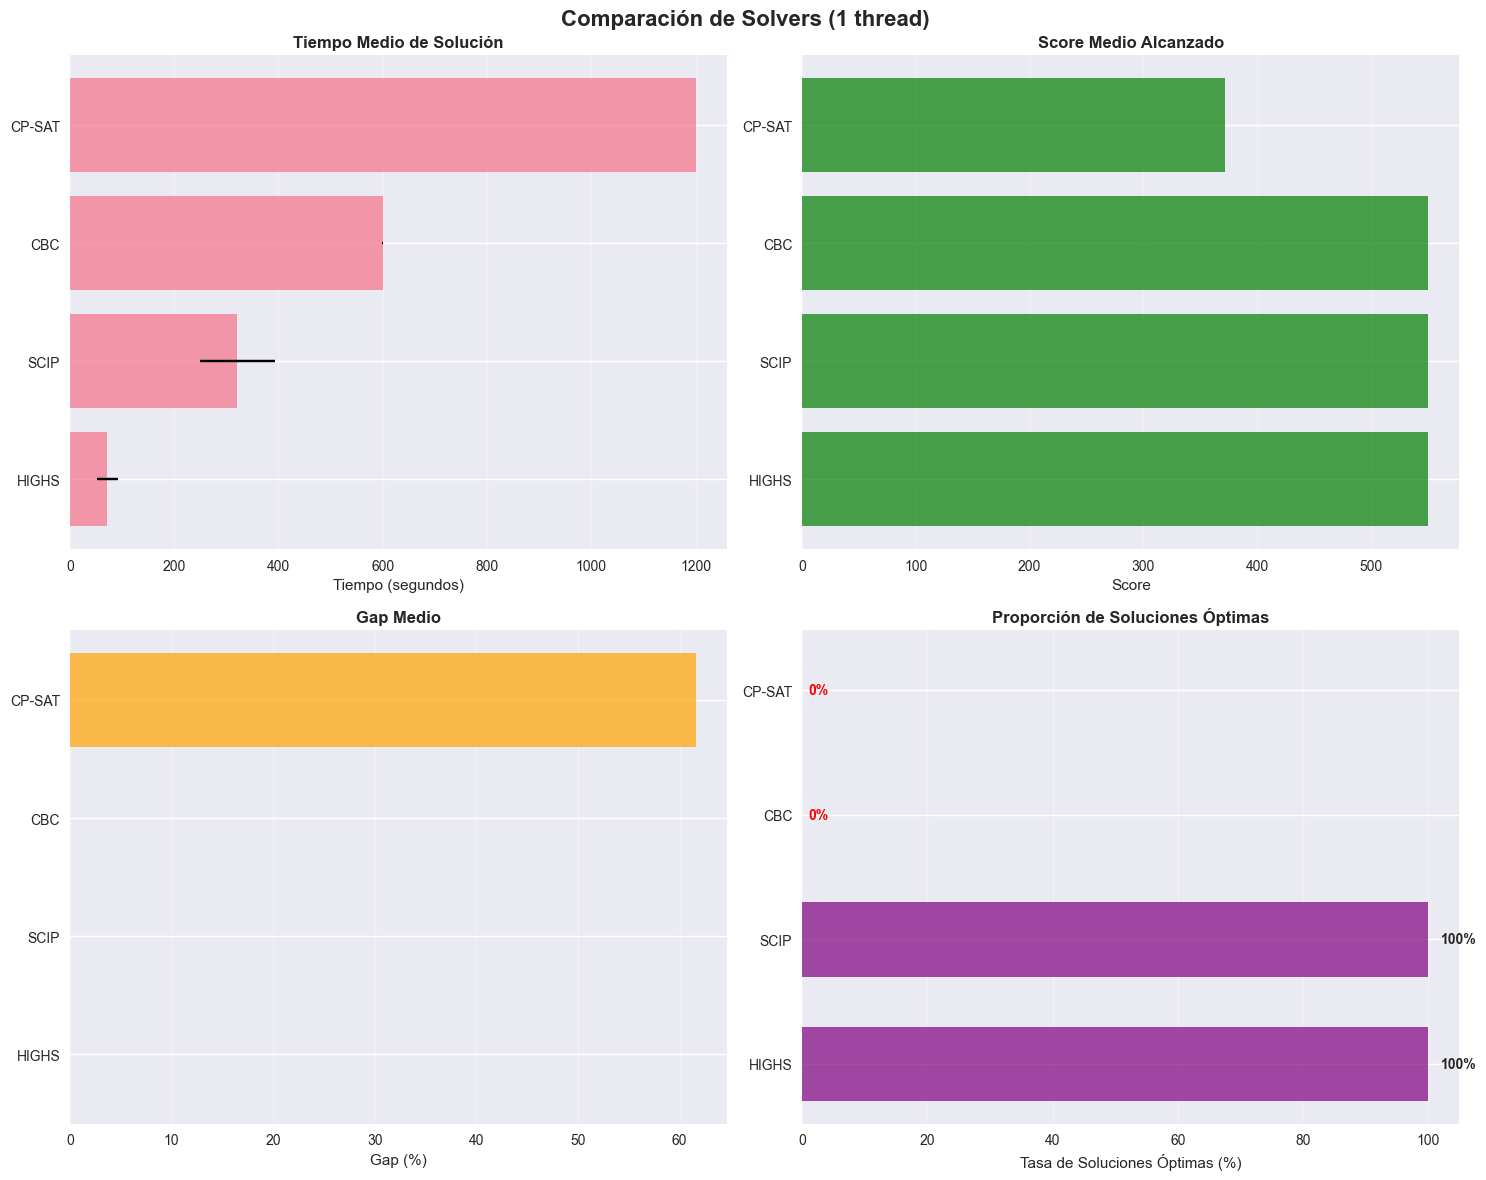

Gráfico guardado como 'comparison_all_solvers.png'


In [ ]:
# Create comparative plot of all solvers
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Solver Comparison (1 thread)', fontsize=16, fontweight='bold')

# Sort solvers by mean time (from lowest to highest)
solver_order = means_by_solver.sort_values('time_mean')['solver'].values
means_sorted = means_by_solver.set_index('solver').loc[solver_order]

# 1. Mean solution time
ax1 = axes[0, 0]
ax1.barh(means_sorted.index, means_sorted['time_mean'], 
         xerr=means_sorted['time_std'], capsize=5, alpha=0.7)
ax1.set_xlabel('Time (seconds)', fontsize=11)
ax1.set_title('Mean Solution Time', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Mean achieved score
ax2 = axes[0, 1]
ax2.barh(means_sorted.index, means_sorted['score_mean'], 
         xerr=means_sorted['score_std'], capsize=5, alpha=0.7, color='green')
ax2.set_xlabel('Score', fontsize=11)
ax2.set_title('Mean Achieved Score', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Mean gap - SHOW ALL SOLVERS
ax3 = axes[1, 0]
# Show all solvers, even if they have gap=0
ax3.barh(means_sorted.index, means_sorted['gap_mean'], 
         xerr=means_sorted['gap_std'], capsize=5, alpha=0.7, color='orange')
ax3.set_xlabel('Gap (%)', fontsize=11)
ax3.set_title('Mean Gap', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
# Ensure x-axis shows values from 0
ax3.set_xlim(left=0)

# 4. Optimal solution rate - SHOW ALL SOLVERS
ax4 = axes[1, 1]
# Calculate percentage values
opt_percentages = means_sorted['opt_rate'] * 100
# Create horizontal bars
bars = ax4.barh(means_sorted.index, opt_percentages, alpha=0.7, color='purple', height=0.6)
# Add text labels with values to make them visible even when 0
for i, (solver, value) in enumerate(zip(means_sorted.index, opt_percentages)):
    # Add text with value, positioned slightly to the right of the bar
    if value == 0:
        ax4.text(1, i, f'{value:.0f}%', va='center', fontsize=10, fontweight='bold', color='red')
    else:
        ax4.text(value + 2, i, f'{value:.0f}%', va='center', fontsize=10, fontweight='bold')
ax4.set_xlabel('Optimal Solution Rate (%)', fontsize=11)
ax4.set_title('Proportion of Optimal Solutions', fontsize=12, fontweight='bold')
ax4.set_xlim([0, 105])
ax4.grid(axis='x', alpha=0.3)
# Ensure all y-axis labels are visible
ax4.set_yticks(range(len(means_sorted.index)))
ax4.set_yticklabels(means_sorted.index)

plt.tight_layout()
plt.show()

# Save figure
fig.savefig('comparison_all_solvers.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'comparison_all_solvers.png'")


/var/folders/yb/54lc0qws3ml2j8kbzt12t3m00000gn/T/ipykernel_30106/2801037015.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_box, labels=labels, patch_artist=True,


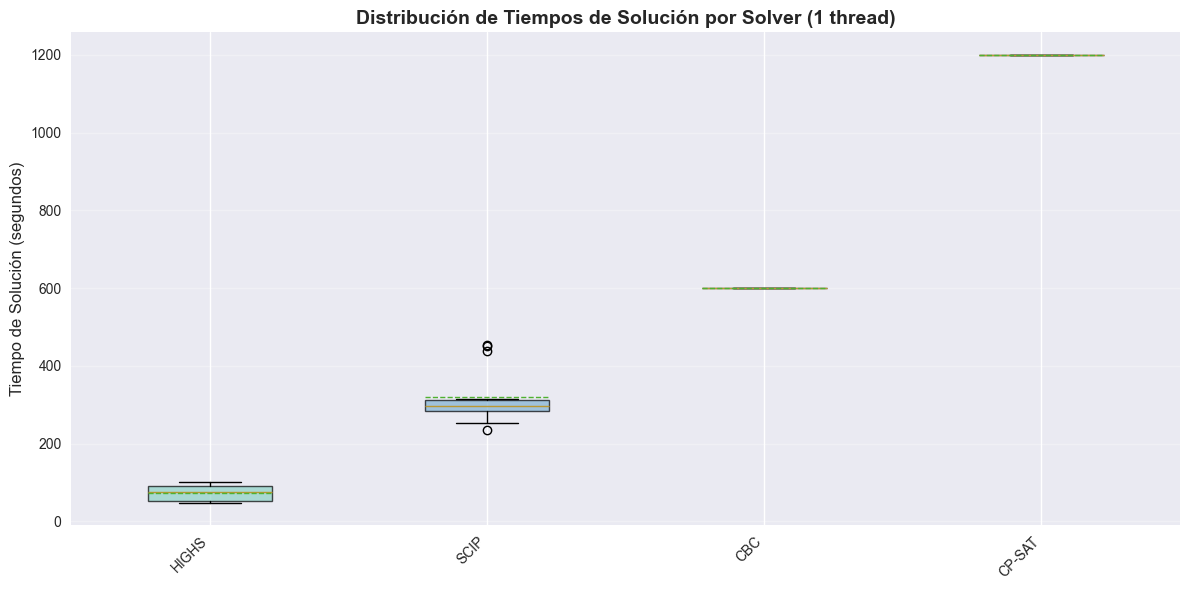

Gráfico guardado como 'boxplot_times_by_solver.png'


In [ ]:
# Comparative box plot of solution times
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for box plot
data_for_box = []
labels = []
for solver in solver_order:
    solver_data = df_comparison[df_comparison['solver'] == solver]['time'].values
    if len(solver_data) > 0:
        data_for_box.append(solver_data)
        labels.append(solver)

bp = ax.boxplot(data_for_box, labels=labels, patch_artist=True, 
                showmeans=True, meanline=True)

# Color the boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Solution Time (seconds)', fontsize=12)
ax.set_title('Distribution of Solution Times by Solver (1 thread)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Save figure
fig.savefig('boxplot_times_by_solver.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'boxplot_times_by_solver.png'")


## Step 4: Analysis of Thread Effect on HIGHS

HIGHS is the best solver according to the previous analysis. Now we analyze how the number of threads affects optimal solution time.


In [ ]:
# Filter only HIGHS data
df_highs = combined_df[combined_df['solver'] == 'HIGHS'].copy()

# Filter only optimal solutions for fair analysis
df_highs_opt = df_highs[df_highs['status'] == 'OPT'].copy()

# Calculate statistics by number of threads
highs_stats = df_highs_opt.groupby('threads').agg({
    'time': ['mean', 'std', 'min', 'max', 'count'],
    'score': ['mean', 'std']
}).round(2)

highs_stats.columns = ['time_mean', 'time_std', 'time_min', 'time_max', 'n_runs', 'score_mean', 'score_std']
highs_stats = highs_stats.reset_index()

print("HIGHS statistics by number of threads (optimal solutions only):")
print(highs_stats.to_string(index=False))

# Calculate percentage improvement
if len(highs_stats) >= 2:
    time_1t = highs_stats[highs_stats['threads'] == 1]['time_mean'].values[0]
    time_8t = highs_stats[highs_stats['threads'] == 8]['time_mean'].values[0]
    improvement = ((time_1t - time_8t) / time_1t) * 100
    print(f"\nImprovement using 8 threads vs 1 thread: {improvement:.2f}% reduction in time")
    print(f"Speedup: {time_1t / time_8t:.2f}x")


Estadísticas de HIGHS por número de threads (solo soluciones óptimas):
 threads  time_mean  time_std  time_min  time_max  n_runs  score_mean  score_std
       1      72.05     19.48     48.27    102.35      30       550.2        0.0
       8      47.01      5.19     35.55     54.88      30       550.2        0.0

Mejora al usar 8 threads vs 1 thread: 34.75% de reducción en tiempo
Speedup: 1.53x


/var/folders/yb/54lc0qws3ml2j8kbzt12t3m00000gn/T/ipykernel_30106/575504059.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([data_1t, data_8t], labels=['1 thread', '8 threads'],


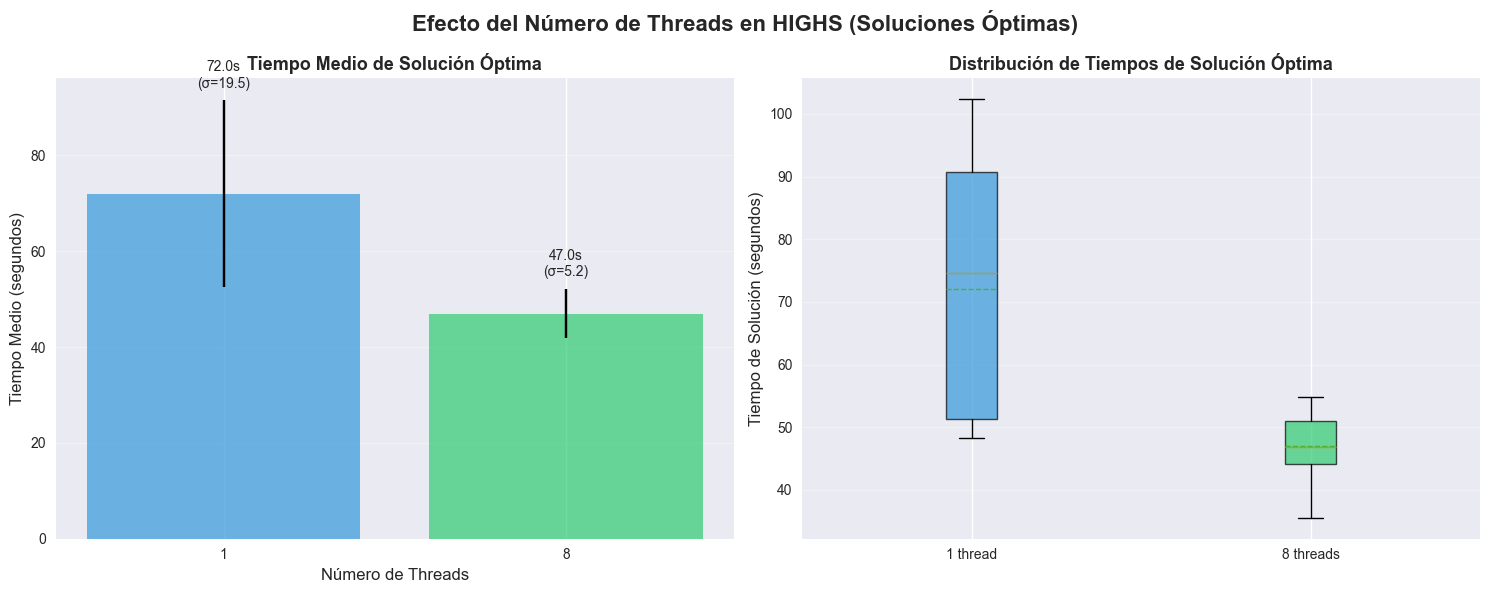

Gráfico guardado como 'highs_threads_analysis.png'


In [ ]:
# Visualization of thread effect on HIGHS
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Effect of Number of Threads on HIGHS (Optimal Solutions)', 
             fontsize=16, fontweight='bold')

# 1. Comparison of mean times
ax1 = axes[0]
threads = highs_stats['threads'].values
time_means = highs_stats['time_mean'].values
time_stds = highs_stats['time_std'].values

bars = ax1.bar(threads.astype(str), time_means, yerr=time_stds, 
                capsize=10, alpha=0.7, color=['#3498db', '#2ecc71'])
ax1.set_xlabel('Number of Threads', fontsize=12)
ax1.set_ylabel('Mean Time (seconds)', fontsize=12)
ax1.set_title('Mean Optimal Solution Time', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add values on bars
for i, (bar, mean, std) in enumerate(zip(bars, time_means, time_stds)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std + 2,
             f'{mean:.1f}s\n(σ={std:.1f})',
             ha='center', va='bottom', fontsize=10)

# 2. Comparative box plot
ax2 = axes[1]
data_1t = df_highs_opt[df_highs_opt['threads'] == 1]['time'].values
data_8t = df_highs_opt[df_highs_opt['threads'] == 8]['time'].values

bp = ax2.boxplot([data_1t, data_8t], labels=['1 thread', '8 threads'], 
                  patch_artist=True, showmeans=True, meanline=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#2ecc71')
for patch in bp['boxes']:
    patch.set_alpha(0.7)

ax2.set_ylabel('Solution Time (seconds)', fontsize=12)
ax2.set_title('Distribution of Optimal Solution Times', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Save figure
fig.savefig('highs_threads_analysis.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'highs_threads_analysis.png'")


In [ ]:
# Save combined dataset for future reference
combined_df.to_csv('combined_experiments_data.csv', index=False)
print("Combined dataset saved as 'combined_experiments_data.csv'")
print(f"\nFinal summary:")
print(f"- Total experiments: {len(combined_df)}")
print(f"- Unique solvers: {combined_df['solver'].unique()}")
print(f"- Thread configurations: {sorted(combined_df['threads'].unique())}")
print(f"- Optimal solutions: {(combined_df['status'] == 'OPT').sum()} ({(combined_df['status'] == 'OPT').sum() / len(combined_df) * 100:.1f}%)")


Dataset combinado guardado como 'combined_experiments_data.csv'

Resumen final:
- Total de experimentos: 94
- Solvers únicos: ['HIGHS' 'CBC' 'SCIP' 'CP-SAT']
- Configuraciones de threads: [np.int64(1), np.int64(8)]
- Soluciones óptimas: 84 (89.4%)
